# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [1]:
!ls pnp_dataset || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip && unzip pnp_dataset.zip >/dev/null 2>&1)

ls: cannot access pnp_dataset: No such file or directory
--2022-10-08 05:23:59--  https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip
Resolving danylo-ucla.s3.us-west-2.amazonaws.com (danylo-ucla.s3.us-west-2.amazonaws.com)... 52.92.163.66
Connecting to danylo-ucla.s3.us-west-2.amazonaws.com (danylo-ucla.s3.us-west-2.amazonaws.com)|52.92.163.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1027495996 (980M) [application/zip]
Saving to: ‘pnp_dataset.zip’

pnp_dataset.zip     100%[===================>] 979.90M  34.6MB/s    in 26s     

2022-10-08 05:24:25 (37.5 MB/s) - ‘pnp_dataset.zip’ saved [1027495996/1027495996]



In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_images(folder: str):
    imgs = []

    paths = !find {folder} -type f
    paths = sorted(paths)

    for path in paths:
        with open(path, 'r') as f:
            imgs.append(plt.imread(path))
            
    return np.array(imgs)

In [2]:
train_x = load_images('pnp_dataset/train_x')
score_x = load_images('pnp_dataset/score_x')
train_y = np.load('pnp_dataset/train_y.npy')

In [5]:
train_x.shape, train_y.shape

((80000, 224, 224, 3), (80000,))

In [6]:
train_y[:5]

array([1, 0, 1, 1, 1])

In [7]:
# split data into training and validation dataset
from sklearn.model_selection import train_test_split
training_set_x, validation_set_x, training_set_y, validation_set_y = train_test_split(train_x, train_y, random_state = 11, test_size = 0.1)

In [8]:
training_set_x.shape, validation_set_x.shape

((72000, 224, 224, 3), (8000, 224, 224, 3))

1

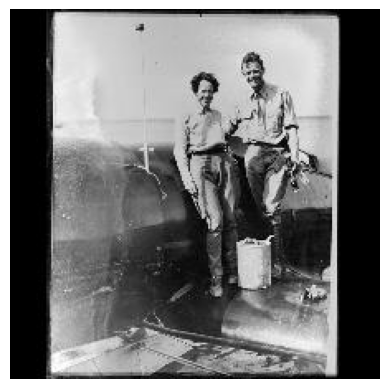

In [9]:
plt.imshow(train_x[0])
plt.axis('off')
train_y[0]

0

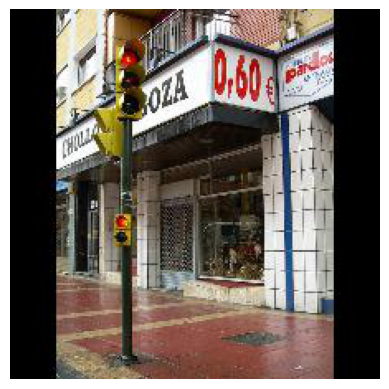

In [10]:
plt.imshow(train_x[1])
plt.axis('off')
train_y[1]

In [11]:
# This configures the GPU to be used by Tensorflow.

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-10-10 00:10:21.511646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 00:10:21.567626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 00:10:21.568573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [42]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

In [43]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

In [14]:
# mobile_net.summary()

In [44]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal', seed=11),
    tf.keras.layers.RandomRotation(0.2, seed=11),
    tf.keras.layers.RandomContrast((0.2,0.8), seed=11),
    #tf.keras.layers.RandomZoom(0.2, seed=11, fill_mode='nearest'), 
    tf.keras.layers.RandomCrop(128,224, seed=11),
    tf.keras.layers.Resizing(224,224),
    tf.keras.layers.Rescaling(1./127.5, offset=-1), # preprocess_input
    mobile_net,
    #tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='ReLU'),
    tf.keras.layers.Dropout(0.2, seed=11),
    tf.keras.layers.Dense(units=1024, activation='ReLU'),
    tf.keras.layers.Dropout(0.2, seed=11),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_contrast_1 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                         
                                                                 
 random_crop_1 (RandomCrop)  (None, 128, 224, 3)       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)      

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)
batch_size = 128

In [18]:
with tf.device('/CPU:0'):
    train_x = tf.constant(train_x)
    train_y = tf.constant(train_y)
    training_set_x = tf.constant(training_set_x)
    training_set_y = tf.constant(training_set_y)
    score_x = tf.constant(score_x)

2022-10-10 00:25:53.810248: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 12042240000 exceeds 10% of free system memory.
2022-10-10 00:26:03.938957: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 10838016000 exceeds 10% of free system memory.
2022-10-10 00:26:12.940786: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3010560000 exceeds 10% of free system memory.


In [47]:
np.random.seed(11)
tf.random.set_seed(11)
model.fit(
    #train_x,
    #train_y,
    training_set_x,
    training_set_y,
    epochs=10,
    batch_size=batch_size,
    validation_data = (validation_set_x, validation_set_y)
)

Epoch 1/10
563/563 [==============================] - 202s 352ms/step - loss: 0.4409 - binary_accuracy: 0.7911 - val_loss: 0.3907 - val_binary_accuracy: 0.8300
Epoch 2/10
563/563 [==============================] - 194s 345ms/step - loss: 0.4009 - binary_accuracy: 0.8115 - val_loss: 0.3286 - val_binary_accuracy: 0.8581
Epoch 3/10
563/563 [==============================] - 194s 345ms/step - loss: 0.3902 - binary_accuracy: 0.8186 - val_loss: 0.3399 - val_binary_accuracy: 0.8489
Epoch 4/10
563/563 [==============================] - 195s 346ms/step - loss: 0.3830 - binary_accuracy: 0.8228 - val_loss: 0.3153 - val_binary_accuracy: 0.8661
Epoch 5/10
563/563 [==============================] - 194s 345ms/step - loss: 0.3803 - binary_accuracy: 0.8238 - val_loss: 0.3058 - val_binary_accuracy: 0.8671
Epoch 6/10
563/563 [==============================] - 195s 346ms/step - loss: 0.3775 - binary_accuracy: 0.8248 - val_loss: 0.3077 - val_binary_accuracy: 0.8691
Epoch 7/10
563/563 [====================

In [67]:
# check performance for validation set and test set
validation_set_y_pred = model.predict(validation_set_x, batch_size=batch_size)
score_y_pred = model.predict(score_x, batch_size=batch_size)

In [68]:
tf.math.confusion_matrix(validation_set_y, (validation_set_y_pred>0.5)*1)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3690,  283],
       [ 699, 3328]], dtype=int32)>

In [74]:
# Tuning by unfreezing some layers in the MobileNetV2 model
len(mobile_net.layers)

154

In [ ]:
#mobile_net.summary()

In [75]:
mobile_net.trainable = True
tune_start = 134
for layer in mobile_net.layers[:tune_start]:
    layer.trainable = False

In [76]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)

In [77]:
np.random.seed(11)
tf.random.set_seed(11)
model.fit(
    training_set_x,
    training_set_y,
    epochs=15,
    initial_epoch = 10,
    batch_size=batch_size,
    validation_data = (validation_set_x, validation_set_y)
)

Epoch 11/15
563/563 [==============================] - 226s 395ms/step - loss: 0.3649 - binary_accuracy: 0.8329 - val_loss: 0.3123 - val_binary_accuracy: 0.8666
Epoch 12/15
563/563 [==============================] - 219s 388ms/step - loss: 0.3375 - binary_accuracy: 0.8485 - val_loss: 0.5824 - val_binary_accuracy: 0.7694
Epoch 13/15
563/563 [==============================] - 218s 388ms/step - loss: 0.3270 - binary_accuracy: 0.8532 - val_loss: 0.3906 - val_binary_accuracy: 0.8364
Epoch 14/15
563/563 [==============================] - 218s 388ms/step - loss: 0.3117 - binary_accuracy: 0.8612 - val_loss: 0.2784 - val_binary_accuracy: 0.8816
Epoch 15/15
563/563 [==============================] - 219s 389ms/step - loss: 0.3054 - binary_accuracy: 0.8628 - val_loss: 0.2841 - val_binary_accuracy: 0.8785


In [78]:
# check performance for validation set and test set
validation_set_y_pred_2 = model.predict(validation_set_x, batch_size=batch_size)
score_y_pred_2 = model.predict(score_x, batch_size=batch_size)

In [79]:
tf.math.confusion_matrix(validation_set_y, (validation_set_y_pred_2>0.5)*1)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3455,  518],
       [ 454, 3573]], dtype=int32)>

In [114]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_x, batch_size=batch_size),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
model.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset

[0.9999095] 1
[0.02297907] 0
[0.73654306] 1
[0.17131826] 0
[0.99427706] 1


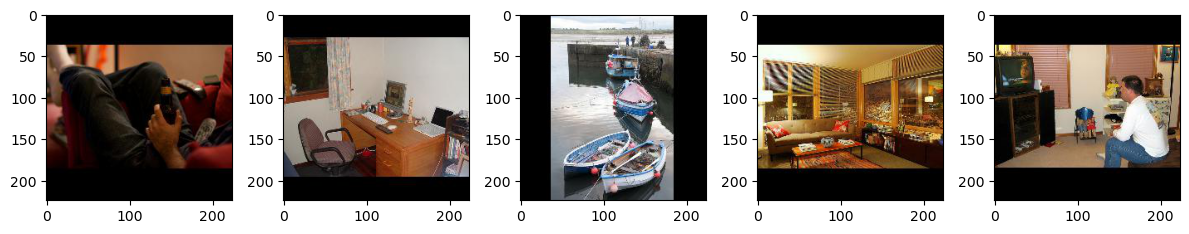

In [62]:
# check performance on validation set
start_pos=200
n=5
fig, axs = plt.subplots(1, n, sharey=False, tight_layout=True, figsize=(12,6))

for i in range(n):
    axs[i].imshow(validation_set_x[start_pos+i])
    print(validation_set_y_pred[start_pos+i], validation_set_y[start_pos+i])

plt.show() 

[0.5238769] 1
[0.99675626] 1
[0.14704691] 1
[0.40882683] 1
[0.03918029] 0


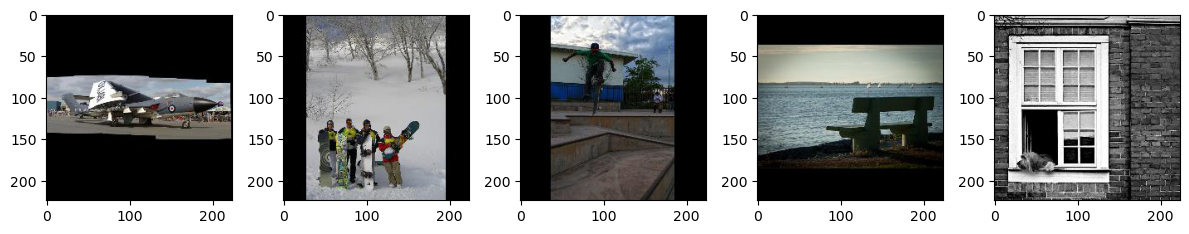

In [92]:
# check performance on validation set
start_pos=300
n=5
fig, axs = plt.subplots(1, n, sharey=False, tight_layout=True, figsize=(12,6))

for i in range(n):
    axs[i].imshow(validation_set_x[start_pos+i])
    print(validation_set_y_pred_2[start_pos+i], validation_set_y[start_pos+i])

plt.show() 

[0.75316817] [ True]
[0.16218892] [False]
[0.8598596] [ True]
[0.8304095] [ True]
[0.49427575] [False]


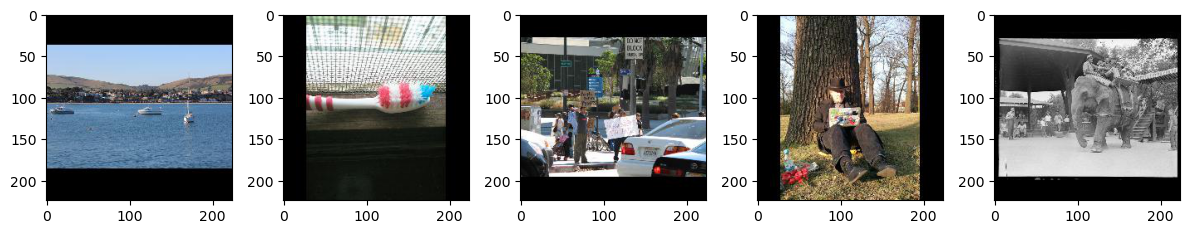

In [66]:
# check performance on test set
start_pos=10
n=5
fig, axs = plt.subplots(1, n, sharey=False, tight_layout=True, figsize=(12,6))

for i in range(n):
    axs[i].imshow(score_x[start_pos+i])
    print(score_y_hat[start_pos+i], score_y_hat[start_pos+i]>0.5)

plt.show() 

[0.07597255] [0]
[0.46546993] [0]
[0.00440584] [0]
[0.9460535] [1]
[0.9999906] [1]


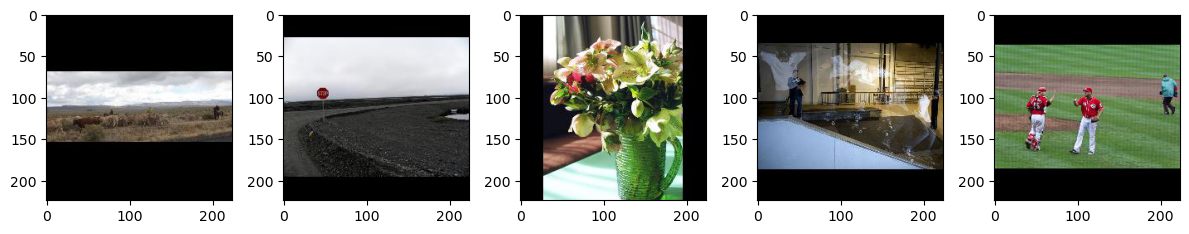

In [113]:
# check performance on test set
start_pos=200
n=5
fig, axs = plt.subplots(1, n, sharey=False, tight_layout=True, figsize=(12,6))

for i in range(n):
    axs[i].imshow(score_x[start_pos+i])
    print(score_y_pred_2[start_pos+i], (score_y_pred_2[start_pos+i]>0.5)*1)

plt.show() 